In [4]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor,XGBModel

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,average_precision_score,r2_score,recall_score,f1_score,roc_auc_score,roc_curve

In [6]:
from google.colab import files
uploaded=files.upload()

Saving train_Df64byy.csv to train_Df64byy (1).csv
Saving test_YCcRUnU.csv to test_YCcRUnU (1).csv


In [7]:
test=pd.read_csv("test_YCcRUnU.csv")
train=pd.read_csv("train_Df64byy.csv")

In [8]:
train.head(5)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [9]:
test.head(5)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [10]:
train.columns,test.columns

(Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
        'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
        'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
        'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
       dtype='object'),
 Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
        'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
        'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
        'Reco_Policy_Cat', 'Reco_Policy_Premium'],
       dtype='object'))

In [11]:
train.shape,test.shape

((50882, 14), (21805, 13))

In [12]:
train.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
dtype: object

Handling Missing Value

In [13]:
numerical_ver=[]
categorical_ver=[]
for col in train.columns:
  if train[col].dtypes=='O':
    categorical_ver.append(col)
  else:
    numerical_ver.append(col)

In [14]:
train.isnull().sum()/len(train.isnull())*100

ID                          0.000000
City_Code                   0.000000
Region_Code                 0.000000
Accomodation_Type           0.000000
Reco_Insurance_Type         0.000000
Upper_Age                   0.000000
Lower_Age                   0.000000
Is_Spouse                   0.000000
Health Indicator           22.976691
Holding_Policy_Duration    39.799929
Holding_Policy_Type        39.799929
Reco_Policy_Cat             0.000000
Reco_Policy_Premium         0.000000
Response                    0.000000
dtype: float64

Now, we see that Health Indicater, Holding_Policy_Duration and Holding_Policy_Type has a 22%, 39% and 39% respectively null values.
 

In [15]:
test.isna().sum()/len(train.isna())*100

ID                          0.000000
City_Code                   0.000000
Region_Code                 0.000000
Accomodation_Type           0.000000
Reco_Insurance_Type         0.000000
Upper_Age                   0.000000
Lower_Age                   0.000000
Is_Spouse                   0.000000
Health Indicator            9.879722
Holding_Policy_Duration    16.907747
Holding_Policy_Type        16.907747
Reco_Policy_Cat             0.000000
Reco_Policy_Premium         0.000000
dtype: float64

In [16]:
def Null_values(df):
  t_na=df.isna()
  null_v=[]
  col=df.columns
  for i in np.arange(df.shape[1]):
    c=col[i]
    s1=0
    for j in np.arange(len(t_na[c])):
      s2=int(t_na[c][j])
      s1=s1+s2
    null_v=np.append(null_v,s1)
  n1=pd.DataFrame([col,null_v]).T
  return n1



In [17]:
Null_values(train)

,0,1
0,ID,0
1,City_Code,0
2,Region_Code,0
3,Accomodation_Type,0
4,Reco_Insurance_Type,0
5,Upper_Age,0
6,Lower_Age,0
7,Is_Spouse,0
8,Health Indicator,11691
9,Holding_Policy_Duration,20251


In [18]:
Null_values(test)

,0,1
0,ID,0
1,City_Code,0
2,Region_Code,0
3,Accomodation_Type,0
4,Reco_Insurance_Type,0
5,Upper_Age,0
6,Lower_Age,0
7,Is_Spouse,0
8,Health Indicator,5027
9,Holding_Policy_Duration,8603


In [19]:
var=['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']
for i in var:
  print(train[i].unique())
  print(train[i].value_counts())

['X1' 'X2' nan 'X4' 'X3' 'X6' 'X5' 'X8' 'X7' 'X9']
X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64
['14+' nan '1.0' '3.0' '5.0' '9.0' '14.0' '7.0' '2.0' '11.0' '10.0' '8.0'
 '6.0' '4.0' '13.0' '12.0']
1.0     4499
14+     4335
2.0     4260
3.0     3586
4.0     2771
5.0     2362
6.0     1894
7.0     1645
8.0     1316
9.0     1114
10.0     813
11.0     546
12.0     513
13.0     511
14.0     466
Name: Holding_Policy_Duration, dtype: int64
[ 3. nan  1.  4.  2.]
3.0    13279
1.0     8173
2.0     5005
4.0     4174
Name: Holding_Policy_Type, dtype: int64


In [20]:
"In train data set Health_Indicator, Holding_Policy_Duration and Holding_Policy_Type are lots of missing values. We see two of categorical data and one of numerical data then we use mode for categorical data and mean for numerical data."

'In train data set Health_Indicator, Holding_Policy_Duration and Holding_Policy_Type are lots of missing values. We see two of categorical data and one of numerical data then we use mode for categorical data and mean for numerical data.'

In [21]:
imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(train.iloc[:,8:11])
train.iloc[:,8:11]=imputer.transform(train.iloc[:,8:11])

In [22]:
imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(test.iloc[:,8:11])
test.iloc[:,8:11]=imputer.transform(test.iloc[:,8:11])

Exploretery Data Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


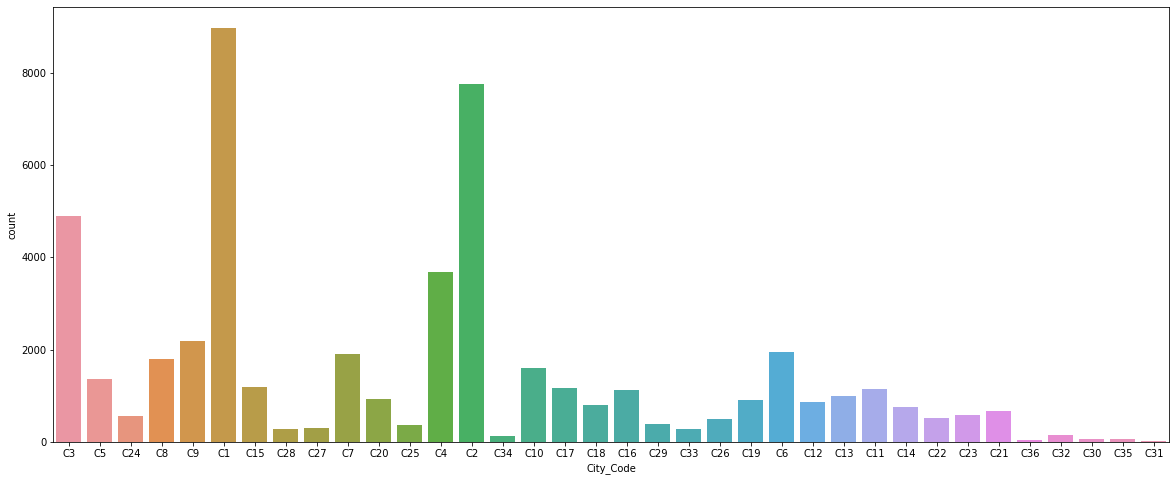

In [23]:
plt.figure(figsize=(20,8))
sns.countplot(train['City_Code'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


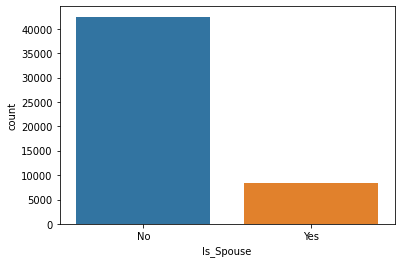

In [24]:
sns.countplot(train['Is_Spouse'])

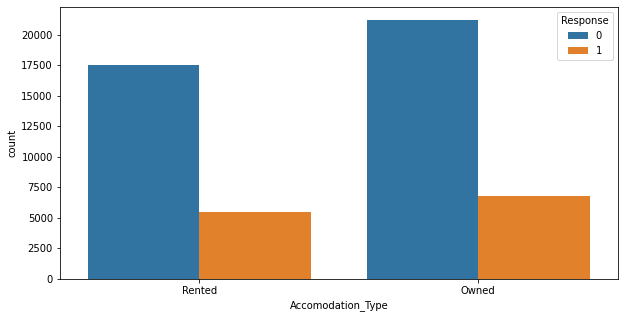

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(data=train,x='Accomodation_Type',hue='Response',)

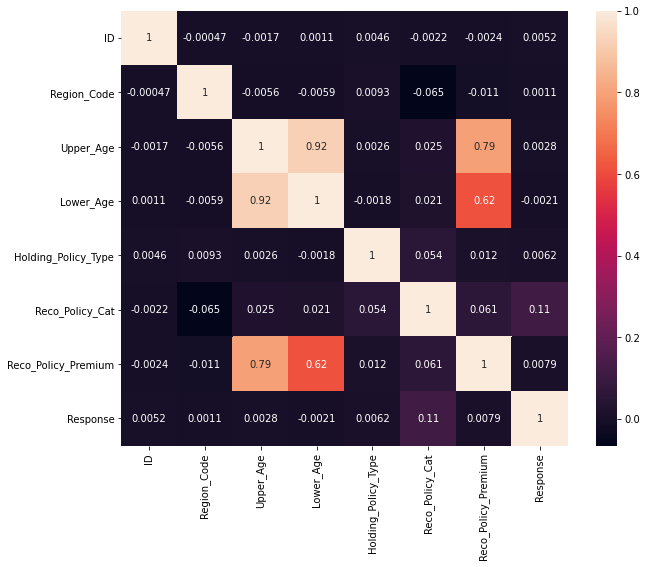

In [26]:
df_corr=train.corr()
f=plt.subplots(figsize=(10,8))
sns.heatmap(df_corr,annot=True)

Text(0.5, 1.0, 'Lower_Age')

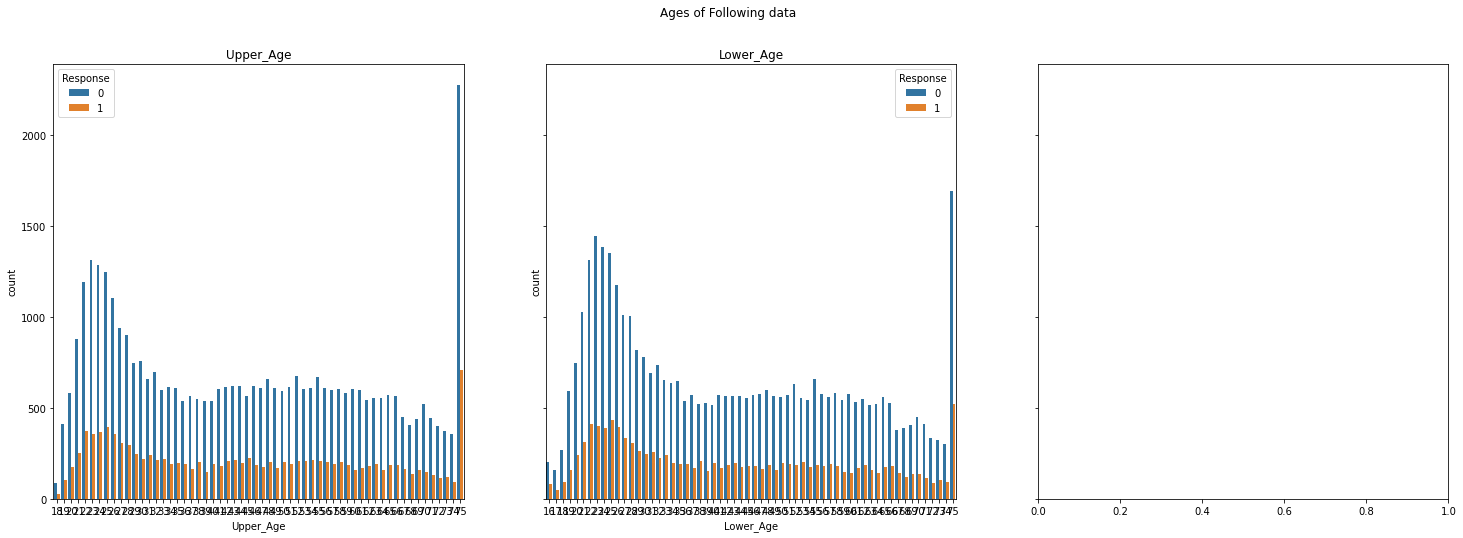

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8), sharey=True)
fig.suptitle('Ages of Following data')
sns.countplot(ax=axes[0],data=train,x='Upper_Age',hue='Response')
axes[0].set_title('Upper_Age')
sns.countplot(ax=axes[1],data=train,x='Lower_Age',hue='Response')
axes[1].set_title('Lower_Age')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


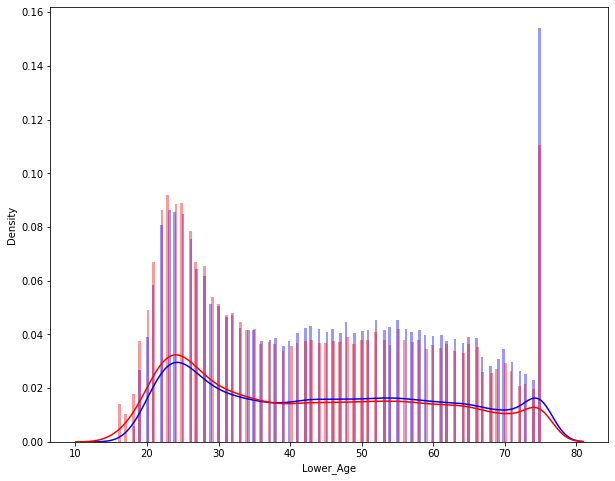

In [28]:
f=plt.subplots(figsize=(10,8))
sns.distplot(train['Upper_Age'],kde=True,color="b",bins=150,)
sns.distplot(train['Lower_Age'],kde=True,color="r",bins=150)

([<matplotlib.patches.Wedge at 0x7f3bd7d2c7d0>,
 [Text(-1.0413846827860378, 0.596253253625189, 'No'),
  Text(1.0413846269607743, -0.5962533511266576, 'Yes')],
 [Text(-0.6074743982918552, 0.3478143979480269, '83.4%'),
  Text(0.6074743657271182, -0.34781445482388357, '16.6%')])

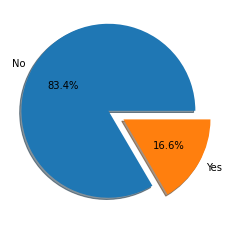

In [29]:
r=pd.get_dummies(train['Is_Spouse'])
r1=(sum(r["No"]),sum(r["Yes"]))
plt.pie(r1,labels=["No","Yes"],shadow=True,explode=(.1,.1),autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x7f3bd7cf39d0>,
 [Text(0.8748982552944408, 0.8213117817751939, 'Responding'),
  Text(-0.8748982168460604, -0.8213118227321361, 'Non-responding')],
 [Text(0.5103573155884238, 0.47909853936886304, '24.0%'),
  Text(-0.5103572931602018, -0.4790985632604127, '76.0%')])

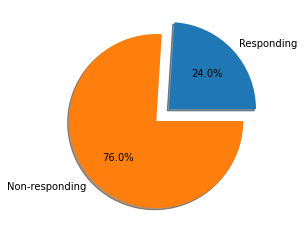

In [30]:
r=pd.get_dummies(train['Response'])
r1=(sum(r[1]),sum(r[0]))
plt.pie(r1,labels=["Responding","Non-responding"],shadow=True,explode=(.1,.1),autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x7f3bd7cc3d50>,
 [Text(-0.185225520311842, 1.1856186176950865, 'Owned'),
  Text(0.18522552031184242, -1.1856186176950865, 'Rented')],
 [Text(-0.10804822018190784, 0.6916108603221337, '54.9%'),
  Text(0.10804822018190806, -0.6916108603221337, '45.1%')])

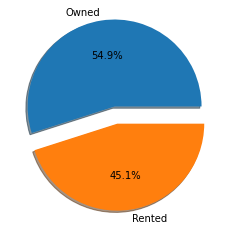

In [31]:
r=pd.get_dummies(train['Accomodation_Type'])
r1=(sum(r["Owned"]),sum(r["Rented"]))
plt.pie(r1,labels=["Owned","Rented"],shadow=True,explode=(.1,.1),autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x7f3bd7c2c490>,
 [Text(0.054808418136604954, 1.1987476954310958, 'X1'),
  Text(-1.0251894281342167, -0.6236879319353854, 'X2'),
  Text(0.03741005475114364, -1.1994167281656183, 'X3'),
  Text(0.8635588524053625, -0.8332263248555781, 'X4'),
  Text(1.1441449176825074, -0.3618458336657874, 'X5'),
  Text(1.1912774302158033, -0.14442328156648407, 'X6'),
  Text(1.199477429494801, -0.03541039582587182, 'X7'),
  Text(1.2998968819686532, -0.01637364492634543, 'X8'),
  Text(1.299990165552388, -0.005056626056493595, 'X9')],
 [Text(0.03197157724635289, 0.6992694890014725, '48.5%'),
  Text(-0.5980271664116263, -0.36381796029564145, '20.3%'),
  Text(0.02182253193816712, -0.6996597580966106, '13.3%'),
  Text(0.503742663903128, -0.48604868949908725, '11.3%'),
  Text(0.6674178686481291, -0.21107673630504262, '3.4%'),
  Text(0.6949118342925519, -0.08424691424711571, '2.5%'),
  Text(0.6996951672053006, -0.02065606423175856, '0.4%'),
  Text(0.7999365427499402, -0.01007608918

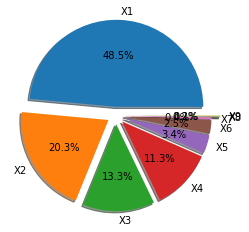

In [32]:
r=pd.get_dummies(train['Health Indicator'])
r1=(sum(r["X1"]),sum(r["X2"]),sum(r["X3"]),sum(r["X4"]),sum(r["X5"]),sum(r["X6"]),sum(r["X7"]),sum(r["X8"]),sum(r["X9"]))
plt.pie(r1,labels=["X1","X2","X3","X4","X5","X6","X7","X8","X9"],shadow=True,explode=(.1,.1,.1,.1,.1,.1,.1,.2,.2),autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x7f3bd7bb1d90>,
 [Text(-0.9633812721178808, 0.7154694434652915, 'Indiviudal'),
  Text(0.9633812721178804, -0.715469443465292, 'Joint')],
 [Text(-0.5619724087354304, 0.4173571753547533, '79.7%'),
  Text(0.5619724087354302, -0.41735717535475364, '20.3%')])

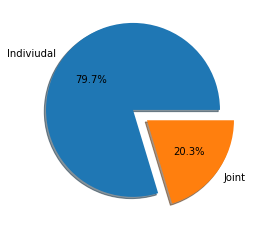

In [33]:
r=pd.get_dummies(train['Reco_Insurance_Type'])
r1=(sum(r["Individual"]),sum(r["Joint"]))
plt.pie(r1,labels=["Indiviudal","Joint"],shadow=True,explode=(.1,.1),autopct='%1.1f%%')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


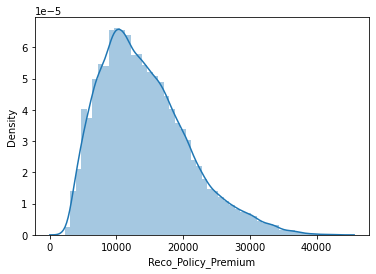

In [34]:
sns.distplot(train['Reco_Policy_Premium'])

<Figure size 720x360 with 0 Axes>

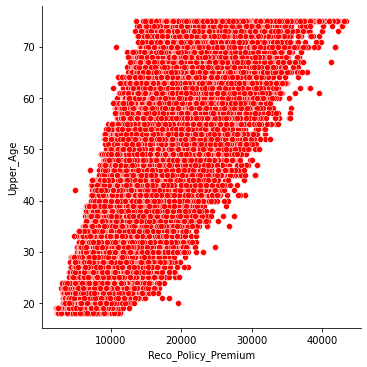

In [35]:
plt.figure(figsize=(10,5))
sns.relplot(data=train,x='Reco_Policy_Premium',y='Upper_Age',color='red')

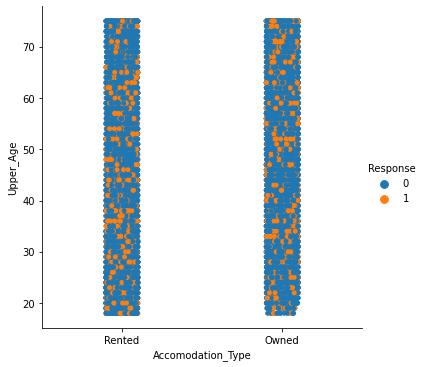

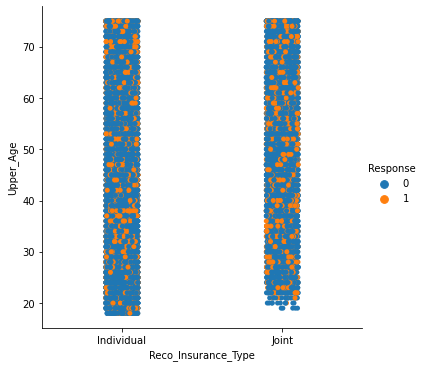

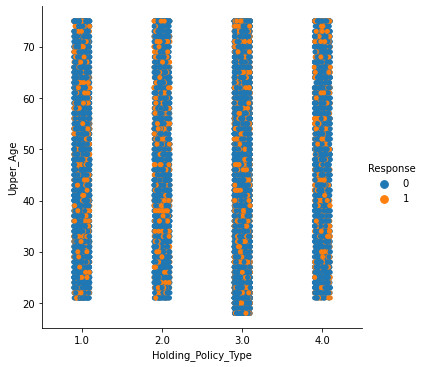

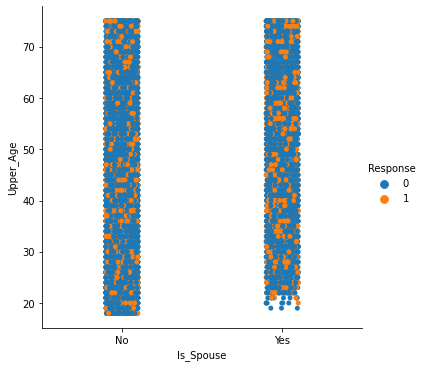

In [36]:
C=['Accomodation_Type','Reco_Insurance_Type','Holding_Policy_Type','Is_Spouse']
for i in C:
    sns.catplot(data=train,x=i,y='Upper_Age',hue='Response',kind="strip")

Feature Engineering

In [37]:
#Removing C in City_Code
train['City_Code']=train['City_Code'].str[1:]
train['City_Code']=train['City_Code'].astype(int)
test['City_Code']=test['City_Code'].str[1:]
test['City_Code']=test['City_Code'].astype(int)

In [38]:
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].replace(to_replace='14+',value=15).astype(float)
test['Holding_Policy_Duration']=test['Holding_Policy_Duration'].replace(to_replace='14+',value=15).astype(float)

In [39]:
train['New_Cus']=np.where(np.logical_and((train['Holding_Policy_Duration']==0),(train['Holding_Policy_Type']==0)),1,0)
test['New_Cus']=np.where(np.logical_and((test['Holding_Policy_Duration']==0),(test['Holding_Policy_Type']==0)),1,0)

In [40]:
train['Accom_Is_Spouse']=train['Accomodation_Type']+"_"+train['Is_Spouse']
test['Accom_Is_Spouse']=test['Accomodation_Type']+"_"+test['Is_Spouse']

In [41]:
train['Accom_are_Reco']=train['Accomodation_Type']+"_"+train['Reco_Insurance_Type']
test['Accom_are_Reco']=test['Accomodation_Type']+"_"+test['Reco_Insurance_Type']

In [42]:
train['Reco_Spou']=train['Is_Spouse']+"_"+train['Reco_Insurance_Type']
test['Reco_Spou']=test['Is_Spouse']+"_"+test['Reco_Insurance_Type']

In [43]:
train['Age_diff']=train['Upper_Age']-train['Lower_Age']
train['Age_diff']=train['Age_diff'].astype(int)
test['Age_diff']=test['Upper_Age']-test['Lower_Age']
test['Age_diff']=test['Age_diff'].astype(int)

In [44]:
train['Family']=np.where(train['Age_diff']>0,1,0)
test['Family']=np.where(test['Age_diff']>0,1,0)

In [45]:
# Now we change categorical to numerical by using One_Hot_Encoding
train['Reco_Insurance_Type']=np.where(train['Reco_Insurance_Type']=="Joint",1,0)
test['Reco_Insurance_Type']=np.where(test['Reco_Insurance_Type']=="Joint",1,0)
train['Is_Spouse']=np.where(train['Is_Spouse']=="Yes",1,0)
test['Is_Spouse']=np.where(test['Is_Spouse']=="Yes",1,0)
train['Accomodation_Type']=np.where(train['Accomodation_Type']=="Owened",1,0)
test['Accomodation_Type']=np.where(test['Accomodation_Type']=="Owened",1,0)
train['Holding_Policy_Type']=train['Holding_Policy_Type'].astype(str)
test['Holding_Policy_Type']=test['Holding_Policy_Type'].astype(str)

In [46]:
dummies_HPT = pd.get_dummies(train["Holding_Policy_Type"], prefix = 'HPT',drop_first=True)
train= pd.concat([train, dummies_HPT], axis = 1)
dummies_HPT = pd.get_dummies(test["Holding_Policy_Type"], prefix = 'HPT',drop_first=True)
test = pd.concat([test, dummies_HPT], axis = 1)

In [47]:
train["log_Premium"]=np.log(train["Reco_Policy_Premium"])
test["log_Premium"]=np.log(test["Reco_Policy_Premium"])

In [48]:
topcity_10=train.City_Code.value_counts().sort_values(ascending=False).head(10).index
lst_10=list(topcity_10)
for categories in lst_10:
    train["City_code:"+str(categories)]=np.where(train['City_Code']==categories,1,0)
    test["City_code:"+str(categories)]=np.where(test['City_Code']==categories,1,0)

In [49]:
topregion_10=train.Region_Code.value_counts().sort_values(ascending=False).head(10).index
lst_10=list(topregion_10)
for categories in lst_10:
    train["Region_code:"+str(categories)]=np.where(train['Region_Code']==categories,1,0)
    test["Region_code:"+str(categories)]=np.where(test['Region_Code']==categories,1,0)

In [50]:
bins = [15,21,30,40,55,75]
labels = ['young','adult','middle-aged','old','very_old']
train['Upper_age_group'] = pd.cut(train['Upper_Age'],bins = bins, labels = labels)
test['Upper_age_group'] = pd.cut(test['Upper_Age'],bins = bins, labels = labels)
train['Lower_age_group'] = pd.cut(train['Lower_Age'],bins = bins, labels = labels)
test['Lower_age_group'] = pd.cut(test['Lower_Age'],bins = bins, labels = labels)

In [51]:
train['Insurance_Age']=np.where((train['New_Cus']==1),0,train['Upper_Age']-train['Holding_Policy_Duration'])
test['Insurance_Age']=np.where((test['New_Cus']==1),0,test['Upper_Age']-test['Holding_Policy_Duration'])

In [52]:
labels= ["not_customer","new_customer","old_customer","valued_customer","Very_valued_customer"]
bins=[-1.0,0.0,5.0,10.0,14.0,15.0]
train["Cust_Acq"] = pd.cut(train["Holding_Policy_Duration"] , labels= labels, bins=bins)
test["Cust_Acq"] = pd.cut(test["Holding_Policy_Duration"] , labels= labels, bins=bins)

In [53]:
train.head(2)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,New_Cus,Accom_Is_Spouse,Accom_are_Reco,Reco_Spou,Age_diff,Family,HPT_2.0,HPT_3.0,HPT_4.0,log_Premium,City_code:1,City_code:2,City_code:3,City_code:4,City_code:9,City_code:6,City_code:7,City_code:8,City_code:10,City_code:5,Region_code:1,Region_code:5,Region_code:2,Region_code:6,Region_code:4,Region_code:10,Region_code:7,Region_code:8,Region_code:16,Region_code:20,Upper_age_group,Lower_age_group,Insurance_Age,Cust_Acq
0,1,3,3213,0,0,36,36,0,X1,15.0,3.0,22,11628.0,0,0,Rented_No,Rented_Individual,No_Individual,0,0,0,1,0,9.361171,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,middle-aged,middle-aged,21.0,Very_valued_customer
1,2,5,1117,0,1,75,22,0,X2,1.0,3.0,22,30510.0,0,0,Owned_No,Owned_Joint,No_Joint,53,1,0,1,0,10.325810,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,very_old,adult,74.0,new_customer


In [54]:
labels= ["below-10k","10k-30k","above-30k"]
bins=[2000,10000,30000,50000]
train["Premium_category"] = pd.cut(train["Reco_Policy_Premium"] , labels= labels, bins=bins)
test["Premium_category"] = pd.cut(test["Reco_Policy_Premium"] , labels= labels, bins=bins)

In [55]:
dummies_HPT = pd.get_dummies(train["Premium_category"], prefix = 'PRE_CAT',drop_first=True)
train= pd.concat([train, dummies_HPT], axis = 1)
dummies_HPT = pd.get_dummies(test["Premium_category"], prefix = 'PRE_CAT',drop_first=True)
test= pd.concat([test, dummies_HPT], axis = 1)
train.drop("Premium_category",axis=1,inplace=True)
test.drop("Premium_category",axis=1,inplace=True)

In [56]:
train['Upper_age_group']=train['Upper_age_group'].astype(str)
test['Upper_age_group']=test['Upper_age_group'].astype(str)
train['Lower_age_group']=train['Lower_age_group'].astype(str)
test['Lower_age_group']=test['Lower_age_group'].astype(str)
train["Cust_Acq"]=train["Cust_Acq"].astype(str)
test["Cust_Acq"]=test["Cust_Acq"].astype(str)

In [57]:
pip install category_encoders

     |████████████████████████████████| 80 kB 3.4 MB/s 


In [58]:
from category_encoders import TargetEncoder
te = TargetEncoder()
train['Region_Code_encoding'] = te.fit_transform(train['Region_Code'].astype(str), train['Response'])
test['Region_Code_encoding'] = te.transform(test['Region_Code'].astype(str))
te=TargetEncoder()
train['City_Code_encoding'] = te.fit_transform(train['City_Code'].astype(str), train['Response'])
test['City_Code_encoding'] = te.transform(test['City_Code'].astype(str))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [59]:
train.drop(["ID","Holding_Policy_Type","Region_Code","City_Code"],axis=1,inplace=True)
test.drop(["ID","Holding_Policy_Type","Region_Code","City_Code"],axis=1,inplace=True)

In [60]:
numerical_ver=[]
categorical_ver=[]
for col in train.columns:
  if train[col].dtypes=='O':
    categorical_ver.append(col)
  else:
    numerical_ver.append(col)

In [61]:
numerical_ver=[]
categorical_ver=[]
for col in test.columns:
  if test[col].dtypes=='O':
    categorical_ver.append(col)
  else:
    numerical_ver.append(col)

In [62]:
for var in categorical_ver:
    le=preprocessing.LabelEncoder()
    train[var]=le.fit_transform(train[var].astype('str'))
train.dtypes

Accomodation_Type            int64
Reco_Insurance_Type          int64
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                    int64
Health Indicator             int64
Holding_Policy_Duration    float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
New_Cus                      int64
Accom_Is_Spouse              int64
Accom_are_Reco               int64
Reco_Spou                    int64
Age_diff                     int64
Family                       int64
HPT_2.0                      uint8
HPT_3.0                      uint8
HPT_4.0                      uint8
log_Premium                float64
City_code:1                  int64
City_code:2                  int64
City_code:3                  int64
City_code:4                  int64
City_code:9                  int64
City_code:6                  int64
City_code:7                  int64
City_code:8                  int64
City_code:10        

In [63]:
for var in categorical_ver:
    le=preprocessing.LabelEncoder()
    test[var]=le.fit_transform(test[var].astype('str'))

In [64]:
#count_0, count_1 = df.Response.value_counts()
#df_count_0 = df[df['Response'] == 0]
#df_count_1 = df[df['Response'] == 1]
#df_count_0_under = df_count_0.sample(count_1)
#df = pd.concat([df_count_0_under, df_count_1], axis=0)
#print('Random over-sampling:')
#print(df.Response.value_counts())
#df.Response.value_counts().plot(kind='bar', title='Count (Rsponse)');

In [65]:
X=train.drop(columns='Response',axis=0)
y=train['Response']

In [66]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   
X_smote, y = sm.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [67]:
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn import metrics
from sklearn.metrics import mean_squared_error
stc=StandardScaler()
X_smote=stc.fit_transform(X_smote)
test=stc.transform(test)

In [68]:
X_smote = pd.DataFrame(X_smote,columns=X.columns)
test=pd.DataFrame(test,columns=X.columns)
X_smote.drop(["City_Code_encoding","Region_Code_encoding",],axis=1,inplace=True)
test.drop(["City_Code_encoding","Region_Code_encoding"],axis=1,inplace=True)

In [69]:
X_train,X_test,y_train,y_test=train_test_split(X_smote,y,test_size=0.4,random_state=22)

In [70]:
xgbc=xgb.XGBClassifier()
xgbc.fit(X_train,y_train)
xgbc_prediction = xgbc.predict(X_train)
xgbc_score= accuracy_score(y_train,xgbc_prediction)
print('accuracy Score on train using XGBClassifier:',xgbc_score)

accuracy Score on train using XGBClassifier: 0.8335380438295946


In [72]:
from sklearn.metrics import mean_absolute_error

In [73]:
a1=mean_absolute_error(y_train,xgbc_prediction)

In [74]:
a1

0.16646195617040532